In [9]:
# combining a transformer with a cellular automata: dna sim
from dna_ca import DNA_CA
import torch
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
from torch.nn import functional as F

batch_size = 4
block_size = 128
max_iter = 5000
epochs = 10
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embed = 64
n_head = 16
n_layer = 32
dropout = 0.2
grid_width = 3
text = []
torch.manual_seed(100)

# create dictionaries and then define unique characters for encoding and decoding
tokens = ['A', 'T', 'C', 'G', '0', '1', 's', 'e']

# Example usage with cellular automata
grid_size = 16  # Grid size for the cellular automata
step_count = 2  # Number of steps to evolve the cellular automata

vocab_size=len(tokens)
stoi = { ch:i for i, ch in enumerate(tokens)}
itos = { i:ch for i, ch in enumerate(tokens)}
enc = lambda s: [stoi['s']] + [stoi[c] for c in s] + [stoi['e']]
dec = lambda l: ''.join([itos[i] for i in l[1:-1]])

#  train and test splits 
def generate_random_input_string(size):
    """Generate a random grid as a string for a given grid size."""
    game1 = DNA_CA(size, grid_width, step_count)
    x = (game1.initialize_grid_with_modifiers())
    return (game1.flatten_grid(x))

def generate_ATCG_sequence(batch_size, grid_size, step_count):
    initial_states = [generate_random_input_string(grid_size) for _ in range(batch_size)]
    final_states = []
    for state in initial_states:
        game = DNA_CA(grid_size, grid_width, step_count)
        final_state_array = game.run_simulation()
        # final_state_str = ''.join(final_state_array.flatten())
        final_states.append(final_state_array)
    return initial_states, final_states

# Define an appropriate size for your validation batch
val_batch_size = batch_size

# load data
def get_batch(batch_size, grid_size, step_count, block_size):
    initial_states, final_states = generate_ATCG_sequence(batch_size, grid_size, step_count)
    X = torch.tensor([enc(s)[:block_size] for s in initial_states], dtype=torch.long)
    Y = torch.tensor([enc(s)[:block_size] for s in final_states], dtype=torch.long)
    return X.to(device), Y.to(device)

# single head attention
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed,head_size,bias=False)
        self.query = nn.Linear(n_embed,head_size,bias=False)
        self.value = nn.Linear(n_embed,head_size,bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) *C**-0.5 # scaled attention
        # wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf')) # decoder block
        wei = F.softmax(wei,dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei@v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        out =  torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.proj(out) # Projection si the linear transformation of the outcome of prev layer
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed,4* n_embed), 
            nn.ReLU(),
            nn.Linear(4* n_embed, n_embed),
            nn.Dropout(dropout),
            )
        self

    def forward(self,x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed //n_head
        self.sa = MultiHeadAttention(n_head,head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
    
    def forward(self,x):
        x = x + self.sa(self.ln1(x)) # add x for residual connections
        x = x + self.ffwd(self.ln1(x))
        return x

class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size,n_embed)
        self.blocks = nn.Sequential(*[Block(n_embed,n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed,vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self,idx,targets=None):
        B,T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device))
        x = tok_emb+pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        # print(f"logits are shape {logits.shape} are: {logits} for idx: {idx}")
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(-1, vocab_size)  # Reshape logits to [batch_size * block_size, vocab_size]
            targets = targets.view(-1)  # Flatten targets to [batch_size * block_size]
            # loss = F.cross_entropy(logits, targets)
            loss = F.mse_loss(logits, F.one_hot(targets, num_classes=vocab_size).float())
            # print(f"logits are shape {logits.shape} are: {loss} for idx: {idx}")
        return logits, loss
    
    def generate(self,idx,max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:,-1,:]
            probs = F.softmax(logits,dim=-1)
            idx_next = torch.multinomial(probs,num_samples=1)
            idx=torch.cat((idx, idx_next), dim = 1)
        return idx
    
model = LanguageModel()
m = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
loss = None  # Initialize loss variable outside the loop

for epoch in range(epochs):
    for iter in range(max_iter // epochs):  # Distribute iterations across epochs
        model.train()
        xb, yb = get_batch(batch_size, grid_size, step_count, block_size)
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if iter % eval_interval == 0 and loss is not None:  # Validation logic
            model.eval()
            with torch.no_grad():
                xv, yv = get_batch(val_batch_size, grid_size, step_count, block_size)
                val_logits, val_loss = model(xv, yv)
                print(f"Epoch {epoch}, Iteration {iter}: Training Loss = {loss.item()}, Validation Loss = {val_loss.item()}")
            model.train()

    scheduler.step(val_loss)  # Update the learning rate at the end of each epoch

# Save:
torch.save(model, 'cat_atcg_model.pth')


Epoch 0, Iteration 0: Training Loss = 0.13315506279468536, Validation Loss = 0.1283332109451294
Epoch 1, Iteration 0: Training Loss = 0.06646596640348434, Validation Loss = 0.06703242659568787
Epoch 2, Iteration 0: Training Loss = 0.06839437782764435, Validation Loss = 0.07066626101732254
Epoch 3, Iteration 0: Training Loss = 0.06882544606924057, Validation Loss = 0.06635159254074097
Epoch 4, Iteration 0: Training Loss = 0.0693722814321518, Validation Loss = 0.07025878876447678
Epoch 5, Iteration 0: Training Loss = 0.06921987980604172, Validation Loss = 0.0727827399969101
Epoch 6, Iteration 0: Training Loss = 0.06652132421731949, Validation Loss = 0.06517942994832993
Epoch 7, Iteration 0: Training Loss = 0.06958481669425964, Validation Loss = 0.06941505521535873
Epoch 8, Iteration 0: Training Loss = 0.07180159538984299, Validation Loss = 0.06795158237218857
Epoch 9, Iteration 0: Training Loss = 0.06893263757228851, Validation Loss = 0.07117502391338348
Epoch 00010: reducing learning ra

Input is: C00G11T10A00T10T11A01A00G01T01C01C11T11G00T00T10G00A10G00T01C01G00G01T11G10A11A00G11C01T00C10A10G10G01C00G11T00T00A00C01T01C11C01G10A00C10C00C11T10G11G11T10T11C00A00G00A00C11G00C01A01A10C00A00
Generated from T is: C00G11T10A00T10T11A01A00G01T01C01C11T11G00T00T10G00A10G00T01C01G00G01T11G10A11A00G11C01T00C10A10G10G01C00G11T00T00A00C01T01C11C01G10A00C10C00C11T10G11G11T10T11C00A00G00A00C11G00C01A01A10C00A00e1GCGCsGe1AAeGT1eG01AACss010sTGCCGC1TTseGC000s0C1eC1CT0A0GsGACseC0T0sATsAsG0100GAsTsT0TsG0CA1TAsCGCG0G1sCGGCTTAeG0CTAGCGTGCss00TsCAseGAsGGTesGATGCGsA000CsAe1eCGesGTT1Cs1s00010GGCCA01111T1s1TTG
Generated from CA is: T10G11T10G11G11G01G00G01G00A01G00C00G00T01G00G01A01T00A01G01G01G01A00G00

Generated from CA finally is: T10G11T10G11G11G01G00G01G00A01G00C00G00T01G00G01A01T00A01G01G01G01A00G00


Generated from T modified is: 1GCGCsGe1AAeGT1eG01AACss010sTGCCGC1TTseGC000s0C1eC1CT0A0GsGACseC0T0sATsAsG0100GAsTsT0TsG0CA1TAsCGCG0G1sCGGCTTAeG0CTAGCGTGCss00TsCAseGAsGGTesGATGCGsA000CsAe1eCGe

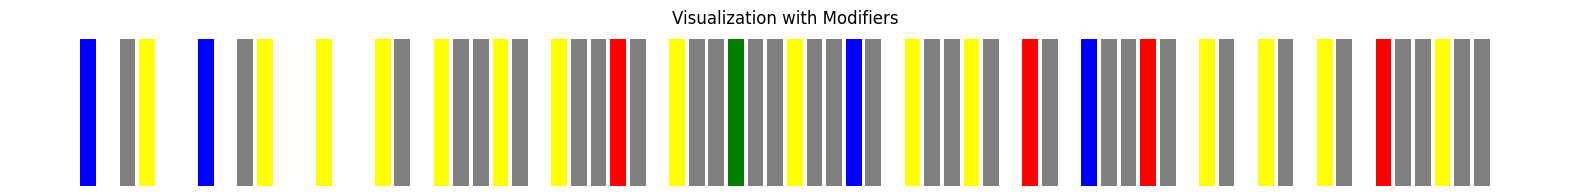

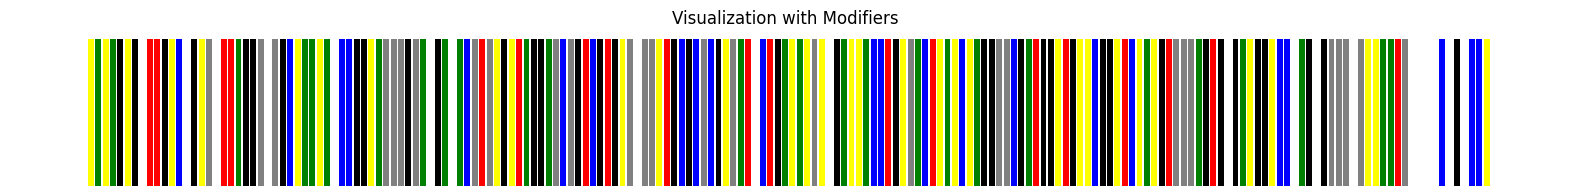

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

model = torch.load('cat_atcg_model.pth')
model.eval()
input_length = 8
generations = 2
grid_length = input_length
grid_width = 3 # Keep it square - no idea why it has to be
game1 = DNA_CA(input_length, input_length, step_count)
x = (game1.initialize_grid_with_modifiers())
input_sequence = (game1.flatten_grid(x))
print(f"Input is: {input_sequence}")
context = torch.tensor(enc(input_sequence), dtype=torch.long, device=device).unsqueeze(0)
output = model.generate(context, max_new_tokens=len(input_sequence))
generated_text_t = dec(output[0].tolist())
game = DNA_CA(grid_length, grid_width, generations=generations)
print(f"Generated from T is: {generated_text_t}")

if generated_text_t.startswith('s'):
    generated_text_t = generated_text_t[1:]

generated_text_ca = game.run_simulation()
_, model_generated_sequence = generated_text_t.split('e', 1)

print(f"Generated from CA is: {generated_text_ca}")

def visualize_grid_with_modifiers(grid):
    """Visualise the grid."""
    base_colors = {'A': 'red', 'T': 'blue', 'C': 'green', 'G': 'yellow', '0': 'grey', '1': 'white', ' ': 'black'}
    colors = []
    
    if isinstance(grid, np.ndarray):  # Handling NumPy arrays from CA generations
        grid = grid.astype(str)  # Ensure the array elements are strings for color mapping
        for generation in grid:
            for cell in generation.flat:
                colors.append(base_colors[cell])
    elif isinstance(grid, str):  # Handling model generated sequences as strings
        for base in grid:
            colors.append(base_colors.get(base, 'black'))  # Default to black for unexpected characters
    
    plt.figure(figsize=(20, 2))
    plt.bar(range(len(colors)), np.ones(len(colors)), color=colors)
    plt.axis('off')
    plt.title('Visualization with Modifiers')
    plt.show()

print(f"\nGenerated from CA finally is: {generated_text_ca}\n")
print(f"\nGenerated from T modified is: {model_generated_sequence}\n")
visualize_grid_with_modifiers(generated_text_ca)
visualize_grid_with_modifiers(model_generated_sequence)  # Use the fixed, split decoded output

# ca = game.unflatten_string(generated_text_ca)
# t = game.unflatten_string(model_generated_sequence)
# game.visualize_grid_with_modifiers(ca)
# game.visualize_grid_with_modifiers(t)  # Use the fixed, split decoded output